<a href="https://colab.research.google.com/github/Carvas91/PyTroch/blob/main/Rice_DF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: carvas91
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 788MB/s]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchsummary import summary


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [6]:
df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
df.drop('id', axis=1, inplace=True)
df.head(5)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [8]:
df.dropna(inplace=True)
df.shape

(18185, 11)

In [9]:
df.Class.unique(), df.Class.value_counts()

(array([1, 0]),
 Class
 1    9985
 0    8200
 Name: count, dtype: int64)

In [10]:
df.columns

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [11]:
original_df = df.copy()

In [12]:
for col in df.columns:
  df[col] = df[col]/df[col].max()

In [13]:
df.head(5)

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [14]:
X = np.array(df.iloc[:,:-1])
y = np.array(df.Class,dtype=np.int32)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=.5)


In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [17]:
class dataset(Dataset):
  def __init__(self,X,y):
    super().__init__()
    self.X = torch.tensor(X,dtype=torch.float,device=device)
    self.y = torch.tensor(y,dtype=torch.float, device=device)
  def __len__(self):
    return len(self.X)
  def __getitem__(self, index):
    return self.X[index],self.y[index]



In [18]:
train_data = dataset(X_train,y_train)
val_data = dataset(X_val,y_val)
test_data = dataset(X_test,y_test)

In [19]:
train_dataLoader = DataLoader(train_data,batch_size=32,shuffle=True)
val_dataLoader = DataLoader(val_data, batch_size=32, shuffle=True)
test_DataLoader = DataLoader(test_data, batch_size=32, shuffle=True)

In [20]:
for X,y in train_dataLoader:
  print(X)
  print("="*50)
  print(y)
  break

tensor([[0.5985, 0.8460, 0.6222, 0.9759, 0.5700, 0.7736, 0.6468, 0.6762, 0.7179,
         0.7713],
        [0.6511, 0.8445, 0.6766, 0.9646, 0.6240, 0.8069, 0.5933, 0.6947, 0.7398,
         0.7082],
        [0.6323, 0.9025, 0.6142, 0.9845, 0.6017, 0.7952, 0.7812, 0.7081, 0.6916,
         0.8337],
        [0.4970, 0.7963, 0.5456, 0.9838, 0.4733, 0.7050, 0.6702, 0.6318, 0.6827,
         0.8280],
        [0.5820, 0.7742, 0.6620, 0.9545, 0.5561, 0.7629, 0.8000, 0.6446, 0.7681,
         0.6634],
        [0.8185, 0.8273, 0.8617, 0.9134, 0.7860, 0.9047, 0.6501, 0.7251, 0.8538,
         0.5447],
        [0.4589, 0.6957, 0.5758, 0.9597, 0.4367, 0.6774, 0.8159, 0.5710, 0.7718,
         0.6854],
        [0.6507, 0.8573, 0.6653, 0.9691, 0.6176, 0.8067, 0.5997, 0.6959, 0.7370,
         0.7311],
        [0.3149, 0.5242, 0.5345, 0.9188, 0.2992, 0.5611, 0.9510, 0.4537, 0.8388,
         0.5564],
        [0.6804, 0.8012, 0.7378, 0.9411, 0.6420, 0.8249, 0.6547, 0.6730, 0.8240,
         0.6161],
        [0

In [21]:
from typing import Any
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(X.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

In [22]:
summary(model, input_size=(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [23]:
criterion = nn.BCELoss()

optimizer = Adam(model.parameters(),lr=1e-3)

In [39]:
epochs = 10
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []


for i in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for X,y in train_dataLoader:
    y_pred = model(X).squeeze(1)

    batch_loss = criterion(y_pred,y)
    total_loss_train += batch_loss.item()

    acc = (y_pred.round() == y).sum().item()
    total_acc_train += acc

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  with torch.no_grad():
    for X,y in val_dataLoader:
      y_pred = model(X).squeeze(1)

      batch_loss = criterion(y_pred,y)
      total_loss_val += batch_loss.item()

      acc = (y_pred.round()==y).sum().item()
      total_acc_val += acc

  # Append average loss and accuracy per epoch
  total_loss_train_plot.append(round(total_loss_train / len(train_dataLoader.dataset), 4))
  total_loss_val_plot.append(round(total_loss_val / len(val_dataLoader.dataset), 4))

  total_acc_train_plot.append(round(total_acc_train / len(train_data) * 100, 4))
  total_acc_val_plot.append(round(total_acc_val / len(val_data) * 100, 4))

  # Print epoch summary
  print(f'Epoch {i+1} | Train Loss: {total_loss_train_plot[-1]} | Val Loss: {total_loss_val_plot[-1]} | '
        f'Train Acc: {total_acc_train_plot[-1]}% | Val Acc: {total_acc_val_plot[-1]}%')


Epoch 1 | Train Loss: 0.0012 | Val Loss: 0.0015 | Train Acc: 98.7195% | Val Acc: 98.3138%
Epoch 2 | Train Loss: 0.0012 | Val Loss: 0.0016 | Train Acc: 98.6173% | Val Acc: 98.3504%
Epoch 3 | Train Loss: 0.0012 | Val Loss: 0.0015 | Train Acc: 98.7509% | Val Acc: 98.3504%
Epoch 4 | Train Loss: 0.0012 | Val Loss: 0.0015 | Train Acc: 98.6645% | Val Acc: 98.3871%
Epoch 5 | Train Loss: 0.0012 | Val Loss: 0.0015 | Train Acc: 98.7116% | Val Acc: 98.2771%
Epoch 6 | Train Loss: 0.0012 | Val Loss: 0.0015 | Train Acc: 98.7037% | Val Acc: 98.3871%
Epoch 7 | Train Loss: 0.0012 | Val Loss: 0.0015 | Train Acc: 98.7195% | Val Acc: 98.3871%
Epoch 8 | Train Loss: 0.0012 | Val Loss: 0.0017 | Train Acc: 98.7587% | Val Acc: 98.1672%
Epoch 9 | Train Loss: 0.0012 | Val Loss: 0.0015 | Train Acc: 98.7352% | Val Acc: 98.2771%
Epoch 10 | Train Loss: 0.0012 | Val Loss: 0.0015 | Train Acc: 98.6488% | Val Acc: 98.3871%


In [40]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for X,y in test_DataLoader:
    y_pred = model(X).squeeze(1)
    batch_loss_test = criterion(y_pred,y).item()
    total_loss_test + batch_loss_test

    acc = (y_pred.round() == y).sum().item()
    total_acc_test += acc

  avg_loss_test = total_loss_test / len(test_DataLoader.dataset)
  avg_acc_test = total_acc_test / len(test_DataLoader.dataset) * 100

  print(f"Test Loss: {avg_loss_test:.4f} | Test Accuracy: {avg_acc_test:.2f}%")


Test Loss: 0.0000 | Test Accuracy: 98.61%


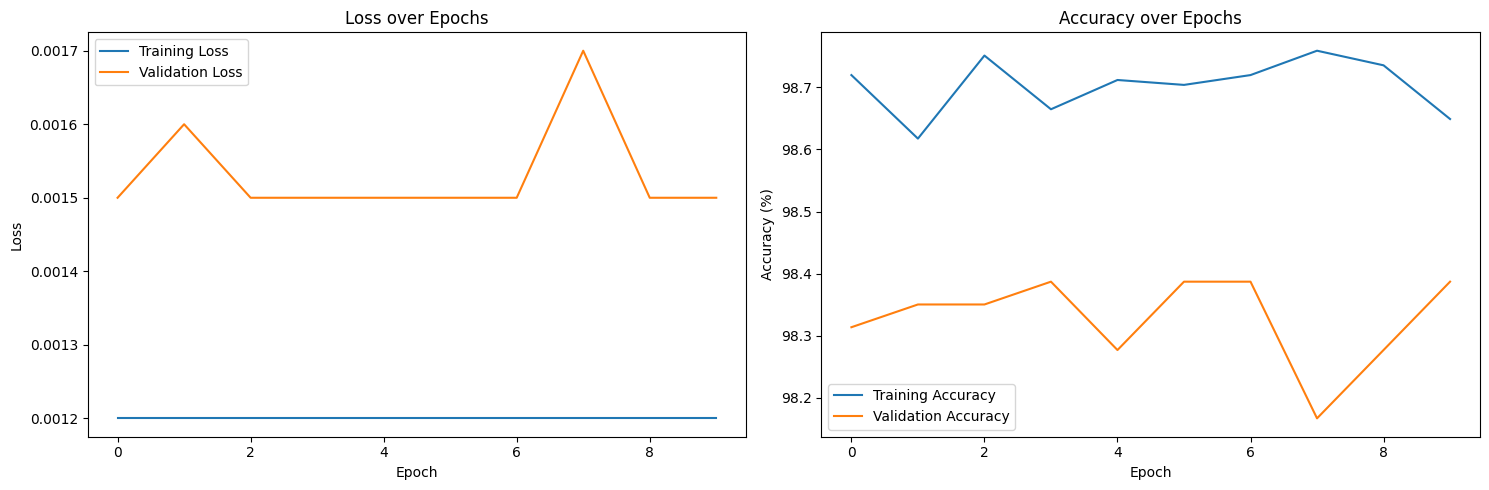

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
axs[0].plot(total_loss_train_plot, label="Training Loss")
axs[0].plot(total_loss_val_plot, label="Validation Loss")
axs[0].set_title("Loss over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot training and validation accuracy
axs[1].plot(total_acc_train_plot, label="Training Accuracy")
axs[1].plot(total_acc_val_plot, label="Validation Accuracy")
axs[1].set_title("Accuracy over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()

plt.tight_layout()
plt.show()
